Evaluate various CNN models on widely known datasets
Support for the article: Radu Dogaru, Ioana Dogaru, "RD-CNN: A Compact and Efficient Convolutional Neural Net for Sound Classification", accepted at ISETC 2020

Run CELL1 or CELL2 for the specific dataset 
(some classic sets or ESC50 "spectral" images resulted from RDT processing)  
Then introduce the specific model name (.h5 files and/or ESC datasets must be previously uploaded in the Files tab) 


Run CELL3 and 4 (Runtime set to "NONE" allows evaluate a latency performance closer to a restricted CPU platform)

Copyright - Radu and Ioana Dogaru, 
Last update Oct. 20, 2020 

In [89]:
%tensorflow_version 1.x
# For compatibility with code developed in TF 1.X

TensorFlow is already loaded. Please restart the runtime to change versions.


In [1]:
# CELL 1 Datasets from Keras - MNIST, F_MNIST, CIFAR 
#---------------------------------------------------


import numpy as np
import keras 

dataset='cifar10' # mnist or f-mnist or cifar10 
reduced=0
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist

if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate 
elif  dataset=='cifar10': 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate 
elif  dataset=='cifar100': 
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate 
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255 
inp_chan=np.shape(x_train)[3] 
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# one can choose a lower numbers of training samples (when GPU MEM is overloaded)
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 4s 0us/step
Number of input channels in image: 3


In [90]:
# CELL2 - DATASETS ("spectral" images) OBTAINED from RDT transform 
import scipy.io as sio
import numpy as np

#dict=sio.loadmat('/content/drive/My Drive/Esc-50-RDT-CNN-experim/esc50-2d-214-7-0-0.mat')
dict=sio.loadmat('esc50-2d-214-7-0-0.mat')


x_train=dict['x_train']
x_test=dict['x_test']

y_train=dict['y_train']
y_test=dict['y_test']

'''
#------------- aici posibil divizare dim intrare 
dwn=2
x_train=x_train[:,0:128:dwn,0:128:dwn,:]
x_test=x_test[:,0:128:dwn,0:128:dwn,:]
'''
#----------------------------------------------------

# --- cele de mai jos pentru a corecta o eroare de salvare in format Matlab 

#y_train=np.reshape(y_train,np.shape(y_train)[1])
#y_test=np.reshape(y_test,np.shape(y_test)[1])

num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]
num_classes=np.shape(y_train)[1]


In [91]:
# CELL 3 - load and display the model summary 
from keras.models import load_model
# "Upload" fisierul model in sectiunea "Files" din Google COLAB
#mod=load_model('cifar_90_90.h5')
#mod=load_model('cifar_small_90_05.h5')

mod=load_model('esc50_2d_214_7_0_0_76_50.h5')

mod.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 214, 7, 40)        640       
_________________________________________________________________
activation_34 (Activation)   (None, 214, 7, 40)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 214, 7, 40)        24040     
_________________________________________________________________
activation_35 (Activation)   (None, 214, 7, 40)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 214, 7, 40)        24040     
_________________________________________________________________
batch_normalization_13 (Batc (None, 214, 7, 40)        160       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 214, 7, 40)      

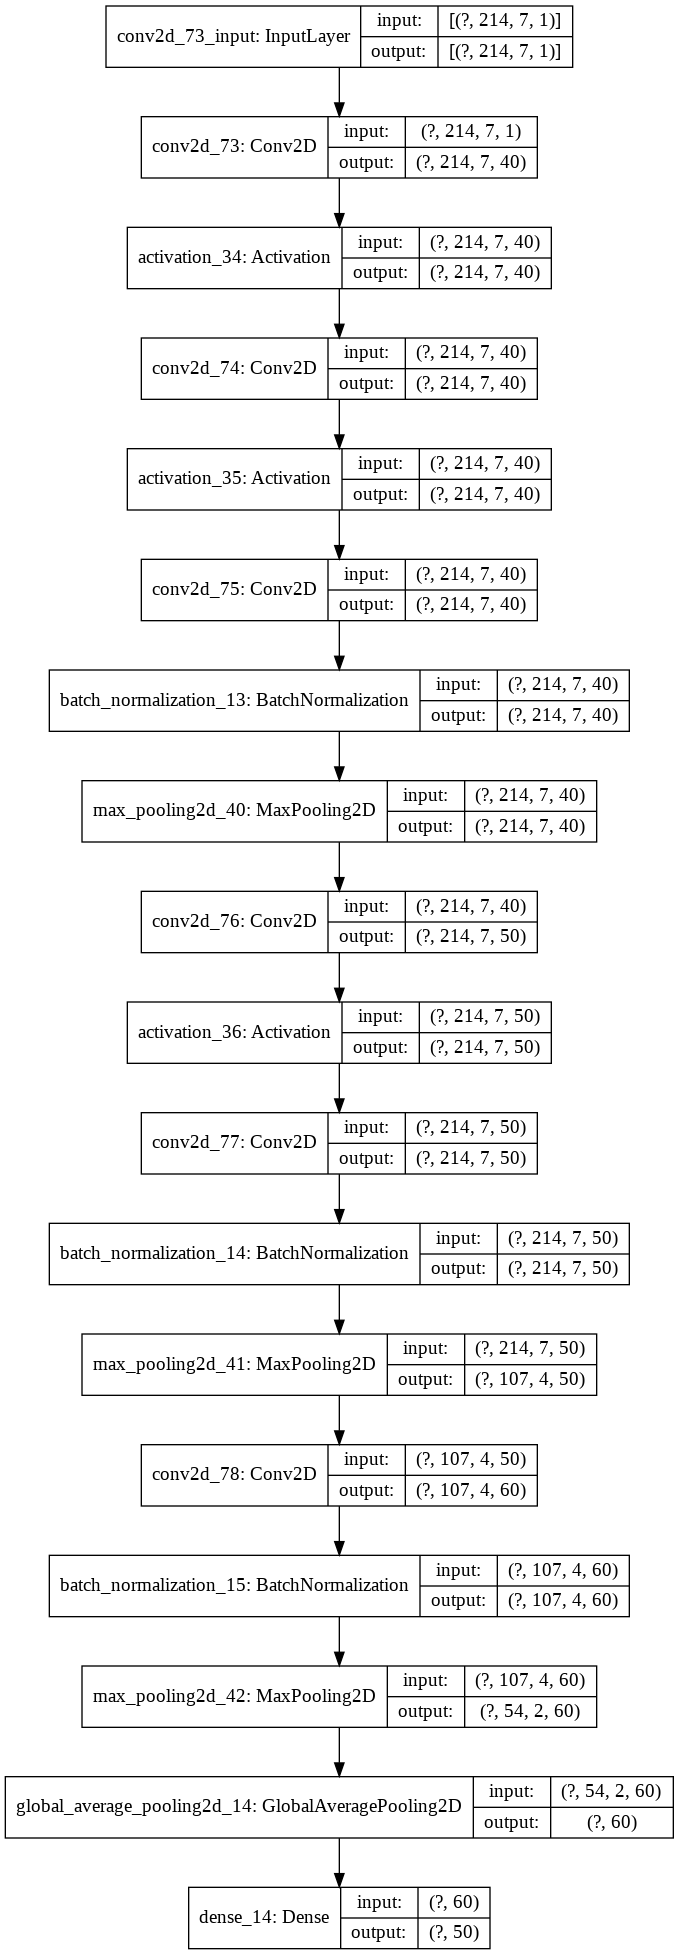

In [92]:
#cfg=mod.get_config()
#cfg
# CELL 4  - eventually a graphical model 
from keras.utils import plot_model
plot_model(mod, show_shapes='True', to_file='model.png')

In [100]:
import time as ti 
t1=ti.time()
score = mod.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print('Test accuracy:', score[1])
print ('Time for test set : ',t2-t1)
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')


Test accuracy: 0.7649999856948853
Time for test set :  0.147308349609375
Latency (per input sample): 0.3682708740234375 ms


Original label : 42.0
Recognized label:  42


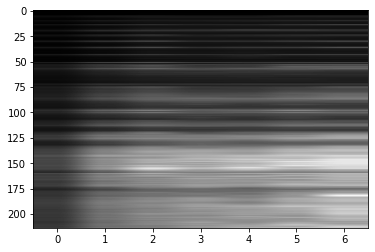

In [101]:
# Random samples prediction

selectia=int(np.shape(x_test)[0]*np.random.rand(1))  # 

img1=x_test[selectia,:,:,:]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if np.shape(x_train)[3]==1:
  plt.imshow(img1[:,:,0],cmap='gray', aspect='auto')
elif np.shape(x_train)[3]==3:
  plt.imshow(img1)

label=np.dot(y_test[selectia,:],1+np.array(range(num_classes)).T)
print('Original label :', label)
z=mod.predict(x_test[selectia:selectia+1,:,:,:])
print('Recognized label: ',1+np.argmax(z))



In [102]:
# Evaluate performance metrics 
# 
#----------------------------------------------------------------

labels=(np.dot(y_test,np.array(range(num_classes)).T)).astype('int16')
pred= mod.predict(x_test)
predicted_class_indices=np.argmax(pred,axis=1)
from sklearn.metrics import classification_report, confusion_matrix
C=confusion_matrix(predicted_class_indices,labels)
print (C)
print('Classification Report')
print(classification_report(labels,predicted_class_indices ))


[[ 4  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0  8  0]
 [ 0  0  0 ...  0  0  5]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.92      0.96        13
           2       0.75      0.60      0.67         5
           3       0.60      0.60      0.60         5
           4       1.00      0.89      0.94         9
           5       0.89      0.80      0.84        10
           6       0.89      1.00      0.94         8
           7       0.57      0.80      0.67        10
           8       0.73      0.80      0.76        10
           9       0.88      0.78      0.82         9
          10       1.00      0.78      0.88         9
          11       0.70      1.00      0.82         7
          12       0.50      0.75      0.60         8
          13       0.83      0.42      0.56        12
          1